# Assignment 2: sentiment analysis of SUTD Reddit
**Assignment due 21 March 11:59pm**

Welcome to the second assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output and a labeled dataset which you create in the assignment will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 150 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [ ]:
# Installing all required packages
# Note: Do not add to this list.
# ----------------
! pip install transformers[torch]==4.37.2
! pip install datasets==2.17.1
! pip install seaborn==0.13.2
! pip install pyarrow==15.0.0
! pip install scikit-learn==1.4.0
! pip install emoji==0.6.0
! pip install accelerate==0.27.2
# ----------------

In [2]:
# Importing all required packages
# ----------------
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
# ----------------

In [3]:
%matplotlib inline

# Sentiment analysis

Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. We have already encountererd sentiment analysis in the hands-on sessions.

In this assignment, you will conduct sentiment analysis on posts and comments from the SUTD subreddit. You will run experiments with pre-trained sentiment models, evaluate their performance and simulate improving the model by re-training it with newly annotated data. 


In [4]:
# Load SUTD subreddit data set as dataframe
# posts and comments have been downloaded from https://www.reddit.com/r/sutd/

df_submissions = pd.read_parquet('reddit_submissions.parquet.gzip').set_index("Id")
df_comments = pd.read_parquet('reddit_comments.parquet.gzip').set_index("CommentId")

In [5]:
#Let's have a look at the data. The data schema is as follows.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time

# Comments
# CommentId - unique id for comment
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
# Id - unique id for submission on which the comment was posted

# See the Reddit API documentation for details https://www.reddit.com/dev/api/
df_submissions

,Title,Upvotes,Created
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35
zzxqop,Happy New Year!,339,2022-12-31 16:26:57
rbe5cz,Happy finals!,319,2021-12-08 00:45:22
zlci46,You know who you are,266,2022-12-14 00:46:23
...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34


In [6]:
# print(df_submissions)

In [7]:
df_comments

,Comment,CommentCreated,Id
CommentId,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4


In [8]:
# print(df_comments)

You can read the SUTD reddit submissions in your web browser by navigating to 
https://www.reddit.com/r/sutd/comments/{Id}


### QUESTION: 
How easy is it to make sense of the submissions and comments? Is it easier to understand the posts when you read them in the browser? 
Explain why or why not (max 100 words)

**--- ADD YOUR SOLUTION HERE (5 points)---**

------------------------------

It is harder to make sense of the submissions and comments by reading it from the DataFrame. The context, formatting, and thread structure are missing. Reading them in the browser is better because of visual cues like indentation, author details, upvotes, and full discussion threads. This can help interpret tone, relevance, and relationships between posts and replies - which is important for sentiment analysis.

In [9]:
# QUESTION: Join the data frames into a joined data_frame 'df_reddit' which  contains both submissions and comments. 
# Each row should contain a submission paired with one associated comment. Comments that do not have a matching submission shall be dropped. The joined data frame should have the following schema.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time
# CommentId - unique id for comment, comment is posted for this submission
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time


#--- ADD YOUR SOLUTION HERE (5 points)---

df_reddit = pd.merge(
    df_comments.reset_index(),
    df_submissions.reset_index(),
    on="Id",
    how="inner"
)[['Id', 'Title', 'Upvotes', 'Created', 'CommentId', 'Comment', 'CommentCreated']]

# df_reddit

#------------------------------

In [10]:
# Print the first 10 rows of the joined data frame
df_reddit.head(10)

# Hint: submission will be duplicated as many times as there are comments

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
5,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j54ub3e,"HEY, FUCK YOU",2023-01-20 12:15:41
6,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2hjzse,"Meanwhile me who has work on christmas eve, ch...",2023-01-01 09:44:48
7,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2i7d80,hahahaaha same,2023-01-01 14:48:55
8,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2m5mdr,f school man,2023-01-02 09:54:47
9,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j4fvc93,Same,2023-01-15 12:41:33


In [11]:
# Now let's run a pre-trained sentiment analysis model on the submissions and comments
# A convenient way to execute pre-trained models for standard tasks are Huggingface pipelines
# Here we run a standard sentiment analysis pipeline on the first ten submission titles 
sentiment_pipeline = pipeline("sentiment-analysis", device=0)
print(df_submissions['Title'][:10])
print(sentiment_pipeline(list(df_submissions['Title'][:10])))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Id
xtdia0                    Oh boy, 8am lectures. My favorite
scyaig                       IF I get my engineering degree
zzxqop                                      Happy New Year!
rbe5cz                                        Happy finals!
zlci46                                 You know who you are
twvwmf                                                 ))))
u4qwja    Not very much studying is gonna get done this ...
ri6w8v             Last paper today freshie bois! Let's go!
qxd05z            >You are T1 Freshie doing the 2D projects
z5uai3                                Data_Driven_World.png
Name: Title, dtype: object
[{'label': 'POSITIVE', 'score': 0.9927398562431335}, {'label': 'NEGATIVE', 'score': 0.7195642590522766}, {'label': 'POSITIVE', 'score': 0.999868631362915}, {'label': 'POSITIVE', 'score': 0.9998632669448853}, {'label': 'POSITIVE', 'score': 0.9992561936378479}, {'label': 'POSITIVE', 'score': 0.5723459720611572}, {'label': 'NEGATIVE', 'score': 0.9995667338371277}, {'labe

In [12]:
# QUESTION: Complete the function 'analyse_sentiment' which takes a data frame, a Huggingface sentiment pipeline object 
# and a target column name and adds two columns 'Label' and 'Score' to the data frame in place.
# pass the provided tokenizer arguments to the pipeline
# The new columns should contain the sentiment labels and scores, respectively.


def analyse_sentiment(df, sentiment_pipeline, column):
    tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':128,}
#--- ADD YOUR SOLUTION HERE (10 points)---
    results = sentiment_pipeline(list(df[column]), **tokenizer_kwargs)
    labels = [result['label'] for result in results]
    scores = [result['score'] for result in results]
    df['Label'] = labels
    df['Score'] = scores
#------------------------------

In [13]:
# add sentiment labels and scores to the submissions and comments dataframes
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')

In [14]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POSITIVE,0.992740
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEGATIVE,0.719564
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POSITIVE,0.999869
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POSITIVE,0.999863
zlci46,You know who you are,266,2022-12-14 00:46:23,POSITIVE,0.999256
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEGATIVE,0.998578
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,POSITIVE,0.845063
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POSITIVE,0.967637


In [15]:
# print(df_submissions)

In [16]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696360
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619021
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651071


In [17]:
# print(df_comments)

### QUESTION: 
From a first inspection of the results, what problems can you see with our current sentiment analysis?
What model is used for the sentiment analysis and how was is trained?

**--- ADD YOUR SOLUTION HERE (5 points) ---**

------------------------------

The current sentiment analysis misclassifies sarcastic or context-specific expressions. For example, “HAHA Issa mood boiii” was labeled negative, even though it's meant to be humorous or relatable. Similarly, subtle negative emotions may be marked as positive due to keyword bias. The default model in HuggingFace sentiment-analysis pipeline uses "distilbert/distilbert-base-uncased-finetuned-sst-2-english", which is trained on movie reviews from the SST-2 dataset. This dataset lacks Reddit-style language, which uses a lot of emojis, slang, and sarcasm, making it unsuitable for social media content like SUTD subreddit comments.


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HF_TOKEN")
print(hf_token)

In [ ]:
# QUESTION: Update the sentiment pipeline to use the model "finiteautomata/bertweet-base-sentiment-analysis" from Huggingface
# The model should output three classes: 'POS', 'NEG', 'NEU'
# Store the model name in separate variable "model_name"

#--- ADD YOUR SOLUTION HERE (5 points) ---

model_name = "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    token=hf_token, # Add your Huggingface token here
    device=0
)

#------------------------------

### QUESTION: 

Explain why this model is better suited for the task (max 100 words).

**--- ADD YOUR SOLUTION HERE (5 points) ---**

------------------------------

The `finiteautomata/bertweet-base-sentiment-analysis` model is pre-trained on social media data, like tweets, which closely resemble Reddit comments in tone, length, slang, and informality. It supports three sentiment classes (POS, NEU, NEG), making it more nuance. Since Reddit posts often contain neutral or sarcastic expressions, this model better captures those contexts compared to models trained on formal datasets like SST-2.


In [20]:
# re-run the sentiment analysis of submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [21]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POS,0.987462
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEU,0.846714
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POS,0.992498
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POS,0.992441
zlci46,You know who you are,266,2022-12-14 00:46:23,NEU,0.611753
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEG,0.825060
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,NEU,0.963418
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POS,0.675288


In [22]:
# print(df_submissions)

In [23]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764860
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932431
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972655
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874082
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180


In [24]:
# print(df_comments)

In [25]:
# QUESTION: What is the time frame covered by the data set, i.e. what is the earliest time of a submission or comment and what is the most recent time?
# Find the earliest and latest timestamp and print them
#--- ADD YOUR SOLUTION HERE (8 points)---

earliest_submission = df_submissions["Created"].min()
latest_submission = df_submissions["Created"].max()
earliest_comment = df_comments["CommentCreated"].min()
latest_comment = df_comments["CommentCreated"].max()

print("Earliest Submission/Comment:", min(earliest_submission, earliest_comment))
print("Latest Submission/Comment:", max(latest_submission, latest_comment))

#------------------------------

Earliest Submission/Comment: 2017-11-12 17:06:27
Latest Submission/Comment: 2024-01-24 03:39:32


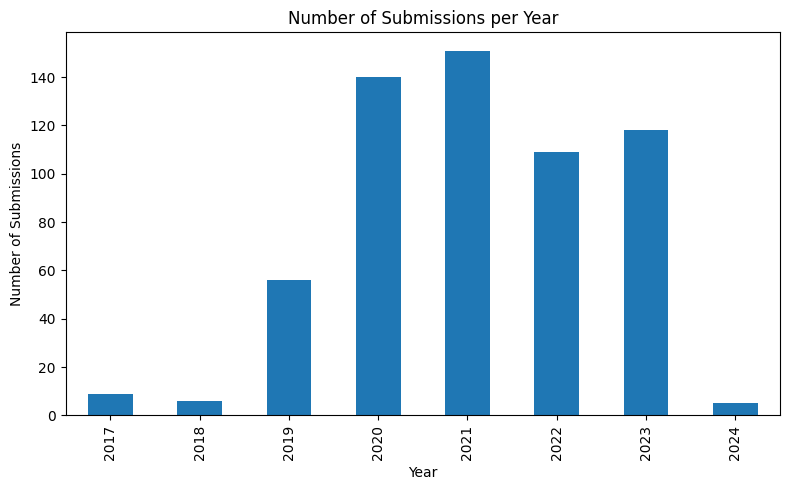

In [26]:
# QUESTION: How did the volume of posts on the SUTD subreddit change over the years?
# Create a bar chart diagram that plots the number of submissions per year on the y-axis and the year on the x-axis.

#--- ADD YOUR SOLUTION HERE (8 points) ---

df_submissions['Year'] = df_submissions['Created'].dt.year
submission_counts = df_submissions['Year'].value_counts().sort_index()

plt.figure(figsize=(8,5))
submission_counts.plot(kind='bar')
plt.title('Number of Submissions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Submissions')
plt.tight_layout()
plt.show()

#------------------------------

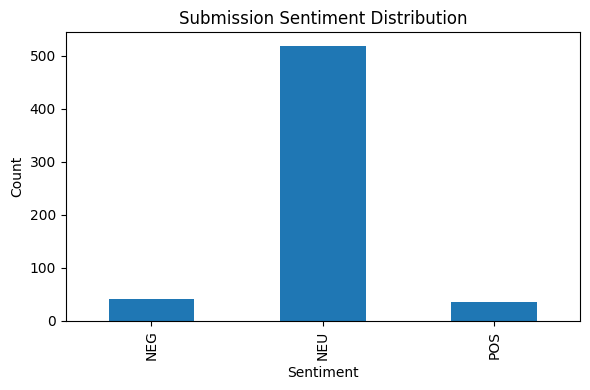

In [27]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment?
# Create a bar chart diagram that plots the number of submissions on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---

sentiment_counts = df_submissions['Label'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar')
plt.title('Submission Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#------------------------------

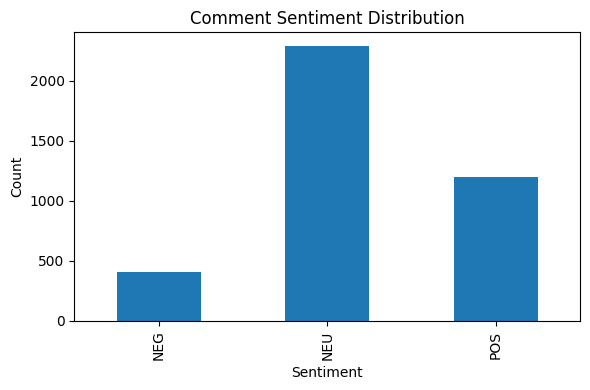

In [28]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment for comments?
# Create a bar chart diagram that plots the number of comments on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---

comment_sentiment_counts = df_comments['Label'].value_counts().sort_index()

plt.figure(figsize=(6,4))
comment_sentiment_counts.plot(kind='bar')
plt.title('Comment Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#------------------------------

In [29]:
# QUESTION: combine submission titles and comments for the time period from 2021 until today into one data frame.
# The resulting data frame 'df_text' should have the following schema

# Id - unique id of the comment or the submissions, this column is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML

#--- ADD YOUR SOLUTION HERE (10 points)---

# Filter
submissions_filtered = df_submissions[df_submissions['Created'] >= '2021-01-01']
comments_filtered = df_comments[df_comments['CommentCreated'] >= '2021-01-01']

# Rename and align
df_sub = submissions_filtered.rename(columns={"Title": "Text"}).loc[:, ["Text", "Created", "Label"]]
df_com = comments_filtered.rename(columns={"Comment": "Text", "CommentCreated": "Created"}).loc[:, ["Text", "Created", "Label"]]

# Set index as ID
df_sub.index.name = "Id"
df_com.index.name = "Id"

# Combine
df_text = pd.concat([df_sub, df_com])
df_text.sort_values("Created", ascending=False, inplace=True)

#------------------------------

In [30]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
kjaudx2,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG
kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
...,...,...,...
ghwf0at,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU


In [31]:
print(df_text)

                                                      Text  \
Id                                                           
kjaudx2  Unfortunately no and I don’t foresee it to cha...   
kjau765  Hi! I would like to ask if it is possible for ...   
kj74anz  Thks! Hope you have a great FEAST II, all the ...   
kj6z72l  I see, wishing you all the best for the result...   
kj6x184  Haha yup, should be out by tmr. Yes, FEAST II ...   
...                                                    ...   
ghwf0at  Yes. I am indoneisan myself. In fact we have a...   
kpde9d                                  Subjects in Year 1   
kp0zuf                             HASS mod recommendation   
kovm76   I am currently still in highschool (indo) and ...   
ghq4jty  woww thank you so much for taking the time to ...   

                    Created Label  
Id                                 
kjaudx2 2024-01-24 03:39:32   NEG  
kjau765 2024-01-24 03:38:13   NEU  
kj74anz 2024-01-23 14:25:22   POS  
kj6z72l 2024-

In [32]:
# QUESTION: sort the data frame by date time descending and save it in the same variable

#--- ADD YOUR SOLUTION HERE (3 points)---
df_text = df_text.sort_values(by="Created", ascending=False)
#------------------------------

In [33]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
kjaudx2,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG
kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
...,...,...,...
ghwf0at,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU


In [34]:
# save data frame to csv
df_text.to_csv("reddit.csv")

Download the csv file and open it in a spreadsheet application or text editor. 

Inspec the first 10-20 entries in the list to get a feeling for the data domain.

### QUESTION: 
Write a short labeling guide for annotating the SUTD reddit data with sentiment labels. 
You can write the labeling guide in a bullet point format and should have 5-10 points.

**--- ADD YOUR SOLUTION HERE (10 points)---**


------------------------------

SUTD Reddit Sentiment Labeling Guide
- POS (Positive): 
In general, the text should expresses joy, appreciation, excitement, humor, encouragement, or general positivity.
- NEG (Negative): 
In general, the text should expresses frustration, anger, complaint, fear, or sadness.
- NEU (Neutral): 
In general, the text should expresses something that is factual, informative, or lacks of emotional tone.
- Emojis and slang should be interpreted in context.
- Replies that is mirror or just echo previous posts without added tone are generally NEU.
- Humor or memes should lean toward POS (unless they include sarcasm or complaint).
- Contextual sarcasm or passive-aggressive statements should lean toward NEG.
- Ambiguous statements should lean toward NEU.
- Apply labels consistently across the dataset.

## Label the data
Add a new column 'HumanLabel' to the csv file and label the 500 most recent entries, including the first 10-20 you inspected to create the label guide, using a spreadsheet application (Excel, Google Docs, Numbers) or just a text editor. 

### QUESTION: 
What were some of the ambiguous cases or corner cases you encountered?
List 3-5 issues

**--- ADD YOUR SOLUTION HERE (30 points)---**  

------------------------------

1. Polite or formal phrases masking negative context  
Example: “The training is difficult as the learning curve is steep.”  
Model labeled it NEU, but I label it as NEG due to implicit struggle. The tone is polite but the sentiment reflects difficulty or stress.

2. One-Word or Very Short Replies  
Example: “i doubt so” or “maybe”  
These are tricky, they could be interpreted as negative, neutral, or hesitant positive, depending on context.

3. Lack of Context in Comment Chains  
Some comments only make sense when paired with the original submission. Without that, interpretation becomes speculative and inconsistent.

4. Conflicting Sentiment Between Text and Emoji  
Example: Text sounds positive but ends with a sad or sarcastic emoji (e.g., “Fun if you join fifth rows that you like. Yeah 😅”).  
It’s unclear whether the sentiment should lean POS, NEU, or NEG.


Upload your 500 labeled instances as **reddit_labeled.csv** to JupyterLab.

## Evaluate
Compare your human-corrected labels with the original predicted labels.

In [ ]:
# 
# QUESTION: Read the 500 labeled rows from the CSV file into a dataframe "df_labeled". 
# The data frame should have this schema.

# Id - unique id of the comment or the submissions, Id is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML
# HumanLabel - manually reviewed 'gold sentiment label'

#--- ADD YOUR SOLUTION HERE (5 points)---
df_labeled = pd.read_csv("reddit_labeled_elvern_tanny.csv", parse_dates=["Created"])

df_labeled.set_index("Id", inplace=True)
#------------------------------

In [88]:
# check the data was loaded correctly
df_labeled

,Text,Created,Label,HumanLabel
Id,,,,
kjaudx2,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG,NEG
kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU,NEU
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS,POS
kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS,POS
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS,POS
...,...,...,...,...
jlsz8pd,Entered having not taken physics since sec 2 b...,2023-05-27 09:33:55,NEU,POS
jlsjszp,Fun if you join fifth rows that you like. Yeah...,2023-05-27 05:57:25,POS,NEU
jls9yp6,"If you have access to a gpu cloud, anything goes",2023-05-27 04:04:37,POS,POS


In [89]:
# split the labeled data into two chunks, ordered by time
df_labeled.sort_values('Created', ascending=True, inplace=True)

df_labeled1 = df_labeled[:250]
df_labeled2 = df_labeled[250:]

In [90]:
# check that the each split is 250 instances and that they don't overlap
df_labeled1


,Text,Created,Label,HumanLabel
Id,,,,
jlpez8k,"hey no worries, feel free to DM if you have an...",2023-05-26 14:45:11,POS,POS
jls8deo,OOo i see!! Any medical examination requiremen...,2023-05-27 03:48:31,NEU,NEU
jls9yp6,"If you have access to a gpu cloud, anything goes",2023-05-27 04:04:37,POS,POS
jlsjszp,Fun if you join fifth rows that you like. Yeah...,2023-05-27 05:57:25,POS,NEU
jlsz8pd,Entered having not taken physics since sec 2 b...,2023-05-27 09:33:55,NEU,POS
...,...,...,...,...
jspjvu2,I am afraid it is rather common for most insti...,2023-07-20 10:03:44,NEG,NEG
jsprthk,"Well, just because it's common doesn't mean it...",2023-07-20 11:31:52,NEG,NEG
jsukd5z,"Hi, if you need a place near sutd dm me",2023-07-21 10:26:32,NEU,NEU


In [91]:
df_labeled2

,Text,Created,Label,HumanLabel
Id,,,,
jtbmjt5,Maybe disappointing but is it very common in a...,2023-07-25 00:32:56,NEG,NEG
jtbrr1z,Hi for me I had to call them directly after ma...,2023-07-25 01:12:56,NEU,NEU
jtceipf,Just email them..! I waited about 3 days after...,2023-07-25 04:22:48,NEU,NEU
jtcz75k,I mean I don't have experience but I always us...,2023-07-25 08:33:15,NEG,NEG
jtjpyao,Ok thanks,2023-07-26 17:16:09,NEU,POS
...,...,...,...,...
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS,POS
kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS,POS
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS,POS


In [92]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 1. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled1["Label"], df_labeled1["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.77      0.68      0.72        25
         NEU       0.93      0.87      0.90       156
         POS       0.79      0.93      0.85        69

    accuracy                           0.87       250
   macro avg       0.83      0.83      0.82       250
weighted avg       0.87      0.87      0.87       250



In [93]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 2. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled2["Label"], df_labeled2["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.74      0.83      0.78        35
         NEU       0.93      0.88      0.90       156
         POS       0.84      0.90      0.87        59

    accuracy                           0.88       250
   macro avg       0.84      0.87      0.85       250
weighted avg       0.88      0.88      0.88       250



## Retrain sentiment model

Now let us use the data in df_labeled1 to try improve the sentiment classifier.
Train the Huggingface model you have chosen with the 250 examples and your human gold labels.

Start by converting the data from data frames into a 2 Huggingface datasets. 
- dataset1 : a Huggingface dataset object which includes the data from dataframe df_labeled1
- dataset2 : a Huggingface dataset object which includes the data from dataframe df_labeled2


In each dataset, there should be the following fields
- text : the text of the reddit submission or comment
- label: the human gold label, encoded as integer

With these dataset we will simulate the process of improving a model in production. Dataset1 is simulating a batch of data which we observed in production, annotated and then use to improve the model. We evaluate the change on the new training data and on the next batch of production data, simulated by dataset2.


In [94]:
def convert_label(df, pipeline):
    # drop predicted label column
    df = df.drop("Label", axis=1)
    # convert string labels to integers as column 'label' using the sentiment pipeline config
    label_id_mapping = lambda label: pipeline.model.config.label2id[label]
    df['label'] = df['HumanLabel'].apply(label_id_mapping)
    return df

df_labeled1 = convert_label(df_labeled1, sentiment_pipeline)
df_labeled2 = convert_label(df_labeled2, sentiment_pipeline)

In [95]:
# QUESTION: Convert the text and human labels from the data frame to a huggingface dataset format
# create a huggingface 'dataset1' from data frame 'df_labeled1' and 'dataset2' from data frame 'df_labeled2' 
#
# each dataset has the following fields
# text : the text of the reddit submission or comment
# label: the human gold label, encoded as integer

#--- ADD YOUR SOLUTION HERE (5 points)---

from datasets import Dataset

dataset1 = Dataset.from_pandas(df_labeled1[["Text", "label"]].rename(columns={"Text": "text"}).reset_index(drop=True))
dataset2 = Dataset.from_pandas(df_labeled2[["Text", "label"]].rename(columns={"Text": "text"}).reset_index(drop=True))

#------------------------------

In [96]:
# inspect the first example
dataset1[0]

{'text': 'hey no worries, feel free to DM if you have any other questions, always happy to help a junior out',
 'label': 2}

In [97]:
# load tokenizer and tokenize data set
# 
# QUESTION: Load the required tokenizer from Huggingface into a variable 'tokenizer'
# Then tokenize 'dataset1' into 'tokenized_dataset1' and 'dataset2' into 'tokenized_dataset2'
# Use the Huggingface libraries. Remember that we stored the model name in a variable "model_name"

# helper function for tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

#--- ADD YOUR SOLUTION HERE (5 points)---

model_name = "finiteautomata/bertweet-base-sentiment-analysis"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_dataset1 = dataset1.map(tokenize_function, batched=True)
tokenized_dataset2 = dataset2.map(tokenize_function, batched=True)

#------------------------------

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [98]:
# load Hugging model for classification initialized with the sentiment model you have chosen

#--- ADD YOUR SOLUTION HERE (3 points)---

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name)

#------------------------------
# Hint: make sure your model corresponds to your tokenizer

In [99]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [100]:

#
# QUESTION: configure the training parameters using the Hugginface TrainingArguments class
# - set the output directory to "finetuning-reddit"
# - do not report training metrics to an external experiment tracking service
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set logging_steps to 10,
# - set evaluation_strategy to "steps",
# - set epochs to 3


#--- ADD YOUR SOLUTION HERE (3 points)---

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuning-reddit",
    report_to="none",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8
)

#------------------------------

c:\Users\ASUS\anaconda3\envs\ai\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [101]:
# initialize trainer
# train on the split dataset1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    eval_dataset=tokenized_dataset2,
    compute_metrics=compute_metrics,
)

In [102]:
# Evaluate on dataset1 set before training 
predictions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset1['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.68      0.72        25
           1       0.93      0.87      0.90       156
           2       0.79      0.93      0.85        69

    accuracy                           0.87       250
   macro avg       0.83      0.83      0.82       250
weighted avg       0.87      0.87      0.87       250



In [103]:
# Evaluate on dataset2 set before training 
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        35
           1       0.93      0.88      0.90       156
           2       0.84      0.90      0.87        59

    accuracy                           0.88       250
   macro avg       0.84      0.87      0.85       250
weighted avg       0.88      0.88      0.88       250



In [104]:
# train the model
train_output = trainer.train()

  0%|          | 0/96 [00:00<?, ?it/s]

{'loss': 0.5317, 'grad_norm': 23.551959991455078, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3580198287963867, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.848, 'eval_precision': 0.8544668327623793, 'eval_recall': 0.848, 'eval_f1': 0.8418545891542737, 'eval_runtime': 1.6314, 'eval_samples_per_second': 153.245, 'eval_steps_per_second': 19.615, 'epoch': 0.31}
{'loss': 0.306, 'grad_norm': 10.445727348327637, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3934594988822937, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.848, 'eval_precision': 0.8592222222222222, 'eval_recall': 0.848, 'eval_f1': 0.8456822300986685, 'eval_runtime': 1.5733, 'eval_samples_per_second': 158.897, 'eval_steps_per_second': 20.339, 'epoch': 0.62}
{'loss': 0.2855, 'grad_norm': 5.294536590576172, 'learning_rate': 1.375e-05, 'epoch': 0.94}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3291862905025482, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.864, 'eval_precision': 0.8735190998433272, 'eval_recall': 0.864, 'eval_f1': 0.8658619307832423, 'eval_runtime': 1.5765, 'eval_samples_per_second': 158.577, 'eval_steps_per_second': 20.298, 'epoch': 0.94}
{'loss': 0.2448, 'grad_norm': 10.072566986083984, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3325319290161133, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.872, 'eval_precision': 0.8777521349639575, 'eval_recall': 0.872, 'eval_f1': 0.8707232783401619, 'eval_runtime': 1.6581, 'eval_samples_per_second': 150.774, 'eval_steps_per_second': 19.299, 'epoch': 1.25}
{'loss': 0.1576, 'grad_norm': 0.6175715327262878, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.29866209626197815, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.88, 'eval_precision': 0.8826988956502141, 'eval_recall': 0.88, 'eval_f1': 0.8781435180143422, 'eval_runtime': 1.5687, 'eval_samples_per_second': 159.368, 'eval_steps_per_second': 20.399, 'epoch': 1.56}
{'loss': 0.113, 'grad_norm': 14.89509391784668, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.33039337396621704, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.88, 'eval_precision': 0.8854753427096315, 'eval_recall': 0.88, 'eval_f1': 0.8808947368421053, 'eval_runtime': 2.1327, 'eval_samples_per_second': 117.22, 'eval_steps_per_second': 15.004, 'epoch': 1.88}
{'loss': 0.0619, 'grad_norm': 1.2736607789993286, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3005695044994354, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.896, 'eval_precision': 0.8964555692067964, 'eval_recall': 0.896, 'eval_f1': 0.8954948229257342, 'eval_runtime': 4.2314, 'eval_samples_per_second': 59.082, 'eval_steps_per_second': 7.562, 'epoch': 2.19}
{'loss': 0.0363, 'grad_norm': 1.0504655838012695, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3149324953556061, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.888, 'eval_precision': 0.8899487106886439, 'eval_recall': 0.888, 'eval_f1': 0.8858275521122564, 'eval_runtime': 4.207, 'eval_samples_per_second': 59.425, 'eval_steps_per_second': 7.606, 'epoch': 2.5}
{'loss': 0.0651, 'grad_norm': 13.19957447052002, 'learning_rate': 1.25e-06, 'epoch': 2.81}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.32861846685409546, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 0.884, 'eval_precision': 0.8862787896611881, 'eval_recall': 0.884, 'eval_f1': 0.8819795511072488, 'eval_runtime': 4.2052, 'eval_samples_per_second': 59.45, 'eval_steps_per_second': 7.61, 'epoch': 2.81}
{'train_runtime': 92.0247, 'train_samples_per_second': 8.15, 'train_steps_per_second': 1.043, 'train_loss': 0.19695733239253363, 'epoch': 3.0}


In [105]:
# Evaluate on dataset1, i.e the training set again
preditions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(preditions.predictions.argmax(-1), dataset1['label']))

  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.99      0.99      0.99       146
           2       1.00      0.98      0.99        83

    accuracy                           0.99       250
   macro avg       0.98      0.99      0.98       250
weighted avg       0.99      0.99      0.99       250



In [106]:
# Evaluate on dataset2 set i.e. the test set again
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.69      0.93      0.79        29
           1       0.93      0.89      0.91       154
           2       0.90      0.85      0.88        67

    accuracy                           0.88       250
   macro avg       0.84      0.89      0.86       250
weighted avg       0.89      0.88      0.89       250



### QUESTION: 
Has the model improved performance on the first batch of data? Does the model generalize well to the next batch of data?
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points)---**

------------------------------


Yes, the model has improved performance on the first batch (dataset1) after re-training as the accuracy increased from 87% to 99%, and all class-wise precision, recall, and F1-scores are nearly perfect. However, on the second batch (dataset2), the performance remains almost the same (~88% accuracy), with a slight improvement in recall for class 0 and in precision for class 2. This indicates that the model has fit the training data very well, but did not show meaningful generalization gains. While not a clear case of overfitting (since test performance didn’t drop), the training-test gap suggests early signs of overfitting, especially with such a small dataset.

### QUESTION: 
Is the model good enough to be used for practical applications?
Given the results you have so far, what additional measures would you recommend to continuously improve the SUTD reddit sentiment classifier? What other functionalities beyond sentiment could be useful? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**


------------------------------

The model performs well overall (88% accuracy on unseen data), therefore it is suitable for practical applications like content moderation or sentiment trend analysis. However, there’s room for improvement. I recommend to periodically retraining the model on fresh data. Beyond sentiment, useful extensions could include emotion classification (e.g., joy, anger, sadness), or topic modeling to track recurring themes.

# End

This concludes assignment 2.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** and the **text file reddit_labeled_STUDENT_NAME.csv** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_02_STUDENT_NAME.ipynb and reddit_labeled_STUDENT_NAME.csv where STUDENT_NAME is your name in your SUTD email address.  
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_02_michael_tan.ipynb



**Assignment due 21 March 2025 11:59pm**

